# Feed-forward сети

Итак, давайте потренируемся тренировать нейронные сети прямого распространения (так как делали на паре)
При этом попробуем создать свою функцию активации на одном из слоев

In [1]:
# Сделаем необходимые импорты
import torch
import numpy as np

from torch import nn
import torchvision
from torch import optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
# https://github.com/matplotlib/matplotlib/issues/21513
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
# Загрузим датасет CIFAR-100, сразу же создадим dataloader для него
# Если вам не хватает вычислительных ресурсов, то можно вернуться к CIFAR-10
train_dataset = torchvision.datasets.CIFAR100(root='data/',
                                             train=True,  
                                             transform=transforms.ToTensor(), 
                                             download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)
test_dataset = torchvision.datasets.CIFAR100(root='./data',
                                             train=False,
                                             transform=transforms.ToTensor(),
                                             download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=1,
                                          shuffle=False)


image, label = train_dataset[0]
print (image.size())
print (label)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([3, 32, 32])
19


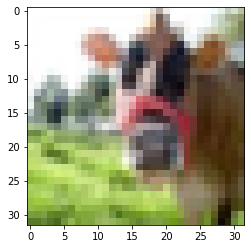

In [4]:
plt.imshow(image.permute(1, 2, 0).numpy())

In [18]:
# Создайте собственную архитектуру! Можете использовать все, что угодно, но в ограничении на использование линейные слои (пока без сверток)
# Давайте добавим ограниченный Leaky_relu, то есть output = max(0.1x, 0.5x)
# Ваша задача добавить его в архитектуру сети как функцию активации
import torch.nn.functional as F

def leaky_relu(x, nk=0.05, pk=1.0):
    return torch.maximum(nk * x, pk * x)
#    return F.leaky_relu(x, nk / pk) * pk


class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, lrnk=0.05, lrpk=1.0):
        super().__init__()
        self.lrnk = lrnk
        self.lrpk = lrpk
        self.fc1 = nn.Linear(input_dim, 4 * hidden_dim)
        self.fc2 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = leaky_relu(x, self.lrnk, self.lrpk)
        x = self.fc2(x)
        x = leaky_relu(x, self.lrnk, self.lrpk)
        x = self.fc3(x)
        x = leaky_relu(x, self.lrnk, self.lrpk)
        x = self.fc4(x)
        if not self.training:
            x = F.softmax(x)
        return x
    
#    def predict(self, x):
#        x = self.forward(x)
#        x = F.softmax(x)
#        return x
    
size = np.prod(image.size())
#net = Net(size, 500, 100, 0.1, 0.5) # с leaky_relu = max(0.1x, 0.5x) модель практически не обучалась
net = Net(size, 500, 100) # тренируем с max(0.05x, x)

print(net)
print(net.training)


Net(
  (fc1): Linear(in_features=3072, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=100, bias=True)
)
True


In [19]:
# Запустить обучение (по аналогии с тем, что делали на паре)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
#optimizer = optim.Adam(net.parameters())


from tqdm import tqdm

report_on = 100
print(net.training)

for epoch in tqdm(range(10)):  
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        if (i+1) % report_on == 0:    # печатаем каждые report_on mini-batches
            print('[%d, %5d] loss: %.3f' %(epoch, i+1, running_loss/report_on))
            running_loss = 0.0

print('Training is finished!')

True


  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

[0,   100] loss: 4.599
[0,   200] loss: 4.562
[0,   300] loss: 4.368
[0,   400] loss: 4.233
[0,   500] loss: 4.140
[0,   600] loss: 4.076
[0,   700] loss: 4.041


 10%|████████▎                                                                          | 1/10 [00:44<06:41, 44.60s/it]

[1,   100] loss: 3.905
[1,   200] loss: 3.893
[1,   300] loss: 3.804
[1,   400] loss: 3.813
[1,   500] loss: 3.782
[1,   600] loss: 3.752
[1,   700] loss: 3.708


 20%|████████████████▌                                                                  | 2/10 [01:29<05:56, 44.59s/it]

[2,   100] loss: 3.656
[2,   200] loss: 3.650
[2,   300] loss: 3.572
[2,   400] loss: 3.631
[2,   500] loss: 3.600
[2,   600] loss: 3.550
[2,   700] loss: 3.553


 30%|████████████████████████▉                                                          | 3/10 [02:13<05:12, 44.62s/it]

[3,   100] loss: 3.486
[3,   200] loss: 3.471
[3,   300] loss: 3.456
[3,   400] loss: 3.426
[3,   500] loss: 3.463
[3,   600] loss: 3.462
[3,   700] loss: 3.442


 40%|█████████████████████████████████▏                                                 | 4/10 [02:58<04:28, 44.69s/it]

[4,   100] loss: 3.345
[4,   200] loss: 3.363
[4,   300] loss: 3.375
[4,   400] loss: 3.329
[4,   500] loss: 3.340
[4,   600] loss: 3.353
[4,   700] loss: 3.352


 50%|█████████████████████████████████████████▌                                         | 5/10 [03:42<03:42, 44.57s/it]

[5,   100] loss: 3.261
[5,   200] loss: 3.250
[5,   300] loss: 3.285
[5,   400] loss: 3.274
[5,   500] loss: 3.234
[5,   600] loss: 3.230
[5,   700] loss: 3.233


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [04:27<02:58, 44.53s/it]

[6,   100] loss: 3.170
[6,   200] loss: 3.203
[6,   300] loss: 3.156
[6,   400] loss: 3.181
[6,   500] loss: 3.151
[6,   600] loss: 3.164
[6,   700] loss: 3.191


 70%|██████████████████████████████████████████████████████████                         | 7/10 [05:12<02:13, 44.57s/it]

[7,   100] loss: 3.056
[7,   200] loss: 3.101
[7,   300] loss: 3.106
[7,   400] loss: 3.079
[7,   500] loss: 3.074
[7,   600] loss: 3.093
[7,   700] loss: 3.090


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [05:56<01:29, 44.58s/it]

[8,   100] loss: 3.048
[8,   200] loss: 3.009
[8,   300] loss: 3.029
[8,   400] loss: 2.999
[8,   500] loss: 2.995
[8,   600] loss: 3.026
[8,   700] loss: 3.056


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [06:41<00:44, 44.54s/it]

[9,   100] loss: 2.936
[9,   200] loss: 2.949
[9,   300] loss: 2.939
[9,   400] loss: 2.946
[9,   500] loss: 2.983
[9,   600] loss: 2.968
[9,   700] loss: 2.944


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:25<00:00, 44.57s/it]

Training is finished!


In [20]:
net.eval()
r = [ (int(true_label), int(torch.argmax(net(image)))) for (image, true_label) in test_loader ]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [21]:
print(f'Точно определено: {sum([t == p for (t, p) in r])/len(test_loader)*100:.02f}% классов')

Точно определено: 23.57% классов
